# AISHELL - 3 - 创建 Mel 频谱图

音频经过了以下的变换：

1. 采样率设置为 `22050hz`
1. `win_length` 设置为 `2048`，`hop_length` 设置为 `1024`
1. Mel 频谱图 [filter-bank](https://librosa.org/doc/latest/generated/librosa.filters.mel.html) 设置为 `80`
1. 将 Mel 频谱图转换成 [power spectrogram](https://librosa.org/doc/latest/generated/librosa.power_to_db.html)
1. 将取值范围调整到 `[-1, 1]`

文本经过以下的变换：

1. 拼音经过 [拼音字典](https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/拼音字典/README.md) 转换成对应的数字索引

In [ ]:
import os
import json
import glob
import datetime
import random
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm

## 挂载 Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 解压数据

数据来自：[AISHELL - 3 - 数据下载](https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/AISHELL-3/notebooks/AISHELL-3-下载数据.ipynb)

In [ ]:
!tar zxvf /content/drive/Shareddrives/TeamDrive_top_edu/原始数据/AISHELL-3/data_aishell3.tgz > unzip_log.txt

## 加载拼音字典

In [ ]:
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper/intonation_5.json
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper/intonation_4.json
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper/intonation_0.json
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper/intonation_fuzzy.json

In [ ]:
with open('intonation_5.json') as f:
  pinyin_mapper_intonation_5 = json.load(f)
  
with open('intonation_4.json') as f:
  pinyin_mapper_intonation_4 = json.load(f)

with open('intonation_0.json') as f:
  pinyin_mapper_intonation_0 = json.load(f)

with open('intonation_fuzzy.json') as f:
  pinyin_mapper_intonation_fuzzy = json.load(f)

## 加载文件列表

In [ ]:
file_list = dict()

for path in glob.glob('/content/train/**/*.wav', recursive=True) + glob.glob('/content/test/**/*.wav', recursive=True):
  name = os.path.splitext(os.path.split(path)[1])[0]
  file_list[name] = path

## 加载音频句子

In [ ]:
sentences = dict()

with open('/content/train/content.txt') as f1:
  with open('/content/test/content.txt') as f2:
    for line in f1.readlines() + f2.readlines():
      name, data = line.strip().split('\t')
      name = name[:-4]
      data = data.split(' ')
      words = data[::2]
      pinyins = data[1::2]

      # 去除带有儿化音的句子
      if all((i in pinyin_mapper_intonation_5 for i in pinyins)):
        sentences[name] = {'words': words, 'pinyins': pinyins}

sentences = list(sentences.items())

打乱顺序

In [ ]:
random.shuffle(sentences)

## 加载朗读者信息

In [ ]:
speaker_info = dict()

with open('/content/spk-info.txt') as f:
  index = 0
  for line in f:
    if line.startswith('S'):
      id, *data = line.strip().split('\t')
      speaker_info[index] = [id, *data]
      speaker_info[id] = [index, *data]
      index += 1

## 构建 [Mel](https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html) 频谱图 数据集

In [ ]:
def create_mel_spectrogram_dataset():
  for name, _ in sentences:
    audio, sr = librosa.load(file_list[name], sr=22050)
    S = librosa.feature.melspectrogram(audio, sr, n_fft=2048, hop_length=1024, n_mels=80, center=False)
    S_dB = librosa.power_to_db(S, ref=np.max) # 这里顺带做了音量统一
    S_dB = (S_dB + 40) / 40
    yield S_dB.T

In [ ]:
mel_dataset = tf.data.Dataset.from_generator(create_mel_spectrogram_dataset, output_signature=tf.TensorSpec(shape=(None, 80), dtype=tf.float32))

查看频谱图

mel频谱形状 (56, 80)


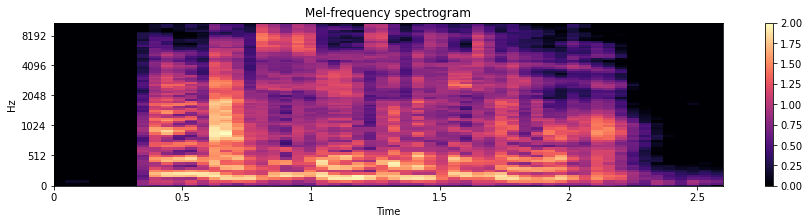

In [ ]:
sample_data = next(mel_dataset.as_numpy_iterator())
print(f'mel频谱形状 {sample_data.shape}')

plt.figure(figsize=(15, 3))
plt.title('Mel-frequency spectrogram')
librosa.display.specshow(sample_data.T + 1, x_axis='time', y_axis='mel', sr=22050, hop_length=1024)
plt.colorbar()

查看音频

In [ ]:
# 由于是使用 Griffin-Lim 算法复原的所以效果不太好，但这并不会影响到语音识别
sample_data = sample_data.T * 40 - 40
sample_data = librosa.db_to_power(sample_data)
sample_data = librosa.feature.inverse.mel_to_audio(sample_data, sr=22050, n_fft=2048, hop_length=1024)
ipd.Audio(sample_data, rate=22050)

## 构建 朗读者 数据集

In [ ]:
def create_speaker_dataset():
  for name, _ in sentences:
    yield (speaker_info[name[:7]][0],)

In [ ]:
speaker_dataset = tf.data.Dataset.from_generator(create_speaker_dataset, output_signature=tf.TensorSpec(shape=(1,), dtype=tf.int32))

查看效果

In [ ]:
speaker_info[next(speaker_dataset.as_numpy_iterator())[0]]

['SSB0038', 'B', 'female', 'north']

## 构建 文本 数据集

In [ ]:
def create_words_dataset():
  for _, text in sentences:
    yield text['words']

In [ ]:
words_dataset = tf.data.Dataset.from_generator(create_words_dataset, output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))

查看效果

In [ ]:
' '.join(map(lambda x: str(x, 'utf-8'), next(words_dataset.as_numpy_iterator())))

'他 们 把 机 器 人 做 得 非 常 友 好'

## 构建 拼音 数据集

In [ ]:
def create_pinyins_dataset():
  for _, text in sentences:
    yield text['pinyins']

In [ ]:
pinyins_dataset = tf.data.Dataset.from_generator(create_pinyins_dataset, output_signature=tf.TensorSpec(shape=(None,), dtype=tf.string))

查看效果

In [ ]:
' '.join(map(lambda x: str(x, 'utf-8'), next(pinyins_dataset.as_numpy_iterator())))

'ta1 men5 ba3 ji1 qi4 ren2 zuo4 de2 fei1 chang2 you2 hao3'

## 构建 拼音索引 数据集

In [ ]:
def create_pinyin_index_dataset(pinyin_mapper):
  def generator():
    for _, text in sentences:
      yield [pinyin_mapper[i] for i in text['pinyins']]
  return generator

In [ ]:
# 五种声调
pinyin_index_5_dataset = tf.data.Dataset.from_generator(create_pinyin_index_dataset(pinyin_mapper_intonation_5), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))

# 四种声调
pinyin_index_4_dataset = tf.data.Dataset.from_generator(create_pinyin_index_dataset(pinyin_mapper_intonation_4), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))

# 无声调
pinyin_index_0_dataset = tf.data.Dataset.from_generator(create_pinyin_index_dataset(pinyin_mapper_intonation_0), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))

# 无声调 + 模糊音
pinyin_index_fuzzy_dataset = tf.data.Dataset.from_generator(create_pinyin_index_dataset(pinyin_mapper_intonation_fuzzy), output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32))

查看效果

In [ ]:
sample_data = next(pinyin_index_5_dataset.as_numpy_iterator())
sample_data = list(map(lambda x: str(x), sample_data))
print(' '.join(map(lambda x: pinyin_mapper_intonation_5[x], sample_data)))
print(' '.join(sample_data))

ta1 men5 ba3 ji1 qi4 ren2 zuo4 de2 fei1 chang2 you2 hao3
1585 989 27 655 1273 1361 2053 306 435 161 1846 582


## 保存数据

In [ ]:
!mkdir AISHELL-3

In [ ]:
mel_cache = mel_dataset.cache('AISHELL-3/audios')
speaker_cache = speaker_dataset.cache('AISHELL-3/speaker')
words_cache = words_dataset.cache('AISHELL-3/words')
pinyins_cache = pinyins_dataset.cache('AISHELL-3/pinyins')
pinyin_index_5_cache = pinyin_index_5_dataset.cache('AISHELL-3/pinyin_index_5')
pinyin_index_4_cache = pinyin_index_4_dataset.cache('AISHELL-3/pinyin_index_4')
pinyin_index_0_cache = pinyin_index_0_dataset.cache('AISHELL-3/pinyin_index_0')
pinyin_index_fuzzy_cache = pinyin_index_fuzzy_dataset.cache('AISHELL-3/pinyin_index_fuzzy')

In [ ]:
with tqdm(total=len(sentences), desc='mel_cache') as pbar:
  for i in mel_cache: pbar.update()

with tqdm(total=len(sentences), desc='speaker_cache') as pbar:
  for i in speaker_cache: pbar.update()

with tqdm(total=len(sentences), desc='words_cache') as pbar:
  for i in words_cache: pbar.update()

with tqdm(total=len(sentences), desc='pinyins_cache') as pbar:
  for i in pinyins_cache: pbar.update()

with tqdm(total=len(sentences), desc='pinyin_index_5_cache') as pbar:
  for i in pinyin_index_5_cache: pbar.update()

with tqdm(total=len(sentences), desc='pinyin_index_4_cache') as pbar:
  for i in pinyin_index_4_cache: pbar.update()

with tqdm(total=len(sentences), desc='pinyin_index_0_cache') as pbar:
  for i in pinyin_index_0_cache: pbar.update()

with tqdm(total=len(sentences), desc='pinyin_index_fuzzy_cache') as pbar:
  for i in pinyin_index_fuzzy_cache: pbar.update()

pinyin_index_fuzzy_cache: 100%|██████████| 86281/86281 [00:40<00:00, 2106.34it/s]


In [ ]:
with open('AISHELL-3/speaker_info.json', 'w') as f:
  json.dump(speaker_info, f)

## 创建说明文件

In [ ]:
readme = '''数据来源：http://www.openslr.org/93/
项目地址：https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/AISHELL-3/README.md
创建时间：{}

数据类型：
audios：音频对应的 mel 频谱图
  {}

speaker：音频对应的朗读者索引
  {}

words：音频对应的文字
  {}

pinyins：音频对应的拼音
  {}

pinyin_index_5：音频对应的五声声调拼音索引
  {}

pinyin_index_4：音频对应的四声声调拼音索引
  {}

pinyin_index_0：音频对应的无声调拼音索引
  {}

pinyin_index_fuzzy：音频对应的无声调加模糊音拼音索引
  {}

示例代码：
>>> data = tf.data.Dataset.from_generator(lambda: None, output_signature=tf.TensorSpec(shape=(None, 80), dtype=tf.float32))
>>> data = data.cache('文件夹路径/audios')
'''

readme = readme.format(
      datetime.datetime.today(),
      mel_cache.element_spec,
      speaker_cache.element_spec,
      words_cache.element_spec,
      pinyins_cache.element_spec,
      pinyin_index_5_cache.element_spec,
      pinyin_index_4_cache.element_spec,
      pinyin_index_0_cache.element_spec,
      pinyin_index_fuzzy_cache.element_spec
    )

with open('AISHELL-3/README.txt', 'w') as f:
  f.write(readme)

## 压缩文件

In [ ]:
!7z a AISHELL-3.7z AISHELL-3 > zip_log.txt

## 保存到 Google Drive

In [ ]:
!cp -r AISHELL-3 /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/

In [ ]:
!cp AISHELL-3.7z /content/drive/Shareddrives/TeamDrive_top_edu/生成数据/AISHELL-3.7z